In [1]:
from typing import Callable
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import  torch.nn.functional as F
import numpy as np
import scipy

In [2]:
# Define the device to be used by student or grader
# I have MPC accelerator, but most people use cuda
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(torch.ones(1, device=device).device)

mps:0


In [3]:
# Define Neural Network
class DenseNet(nn.Module):
    def __init__(self, layers:list[int], nonlinearity:Callable):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j + 1]))

            if j != self.n_layers - 1:
                self.layers.append(nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x

In [4]:
path = 'plate_data.mat'
data = scipy.io.loadmat(path)
torch.set_default_tensor_type(torch.DoubleTensor)
L_boundary = torch.tensor(data['L_boundary'], dtype=torch.float64)
R_boundary = torch.tensor(data['R_boundary'], dtype=torch.float64)
T_boundary = torch.tensor(data['T_boundary'], dtype=torch.float64)
B_boundary = torch.tensor(data['B_boundary'], dtype=torch.float64)
C_boundary = torch.tensor(data['C_boundary'], dtype=torch.float64)
Boundary   = torch.tensor(data['Boundary'], dtype=torch.float64, requires_grad=True)

/Users/edibrlc/miniconda3/envs/stable/lib/python3.12/site-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)


In [5]:
L_boundary.shape

torch.Size([41, 2])

In [6]:
R_boundary.shape

torch.Size([19, 2])

In [7]:
T_boundary.shape

torch.Size([19, 2])

In [8]:
B_boundary.shape

torch.Size([42, 2])

In [9]:
C_boundary.shape

torch.Size([63, 2])

In [10]:
Boundary.shape[0] == sum(
    [t.shape[0] for t in {L_boundary, R_boundary, T_boundary, B_boundary, C_boundary}]
)

True

In [11]:
# truth solution from FEM
disp_truth = torch.tensor(data['disp_data'], dtype=torch.float64)

# connectivity matrix - this helps you to plot the figure but we do not need it for PINN
t_connect  = torch.tensor(data['t'].astype(float), dtype=torch.float64)

# all collocation points
x_full = torch.tensor(data['p_full'], dtype=torch.float64,requires_grad=True)

# collocation points excluding the boundary
x = torch.tensor(data['p'], dtype=torch.float64, requires_grad=True)

# This chooses 50 fixed points from the truth solution, which we will use for part (e)
rand_index = torch.randint(0, len(x_full), (50,))
disp_fix = disp_truth[rand_index,:]

We will use two neural networks for the problem:

NN1: to map the coordinates [x,y] to displacement u

NN2: to map the coordinates [x,y] to the stresses [sigma_11, sigma_22, sigma_12]

What we will do later is to first compute strain by differentiate the output of NN1

And then we compute a augment stress using Hook's law to find an augmented stress sigma_a

And we will require the output of NN2 to match sigma_a  - we shall do this by adding a term in the loss function

This will help us to avoid differentiating NN1 twice (why?)

As it is well known that PINN suffers from higher order derivatives

In [12]:

Disp_layer = [2, 300, 300, 2] # Architecture of displacement net - you may change as you wish
Stress_layer = [2,400,400,3] # Architecture of stress net - you may change as you wish

stress_net = DenseNet(Stress_layer,nn.Tanh) # Note we choose hyperbolic tangent as an activation function here
disp_net =  DenseNet(Disp_layer,nn.Tanh)

# Define material properties
E = 10.
mu = 0.3

stiff = E/(1-mu**2)*torch.tensor([[1,mu,0],[mu,1,0],[0,0,(1-mu)/2]]) # Hooke's law for plane stress
stiff = stiff.unsqueeze(0)

In [13]:
# PINN requires super large number of iterations to converge (on the order of 50e^3-100e^3)
iterations = 80_000
# LR scheduler
lr = 5E-3
step_size = 1_000
gamma = 0.96

# Define loss function
loss_func = nn.MSELoss()

In [14]:
# Broadcast stiffness for batch multiplication later
stiff_bc = stiff
stiff = torch.broadcast_to(stiff, (len(x),3,3))

stiff_bc = torch.broadcast_to(stiff_bc, (len(Boundary),3,3))

params = list(stress_net.parameters()) + list(disp_net.parameters())

# Define optimizer and scheduler
optimizer = torch.optim.Adam(params, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [15]:
loss_train_list = []

In [16]:
for epoch in range(iterations):
    scheduler.step()
    optimizer.zero_grad()

    # To compute stress from stress net
    sigma = stress_net(x)
    # To compute displacement from disp net
    disp     = disp_net(x)

    # displacement in x direction
    u = disp[:,0]
    # displacement in y direction
    v = disp[:,1]

    # find the derivatives
    dudx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),create_graph=True)[0]
    dvdx = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v),create_graph=True)[0]

    # Define strain
    e_11 = dudx[:,0].unsqueeze(1)
    e_22 = dvdx[:,1].unsqueeze(1)
    e_12 = 0.5 * (dudx[:,1] + dvdx[:,0]).unsqueeze(1)

    e = torch.cat((e_11,e_22,e_12), 1)
    e = e.unsqueeze(2)

    # Define augment stress
    sig_aug = torch.bmm(stiff, e).squeeze(2)

    # Define constitutive loss - forcing the augment stress to be equal to the neural network stress
    loss_cons = loss_func(sig_aug, sigma)

    # find displacement and stress at the boundaries
    disp_bc = disp_net(Boundary)
    sigma_bc = stress_net(Boundary)
    u_bc = disp_bc[:,0]
    v_bc = disp_bc[:,1]

    # Compute the strain and stresses at the boundary
    dudx_bc = torch.autograd.grad(u_bc, Boundary, grad_outputs=torch.ones_like(u_bc),create_graph=True)[0]
    dvdx_bc = torch.autograd.grad(v_bc, Boundary, grad_outputs=torch.ones_like(v_bc),create_graph=True)[0]

    e_11_bc = dudx_bc[:,0].unsqueeze(1)
    e_22_bc = dvdx_bc[:,1].unsqueeze(1)
    e_12_bc = 0.5 * (dudx_bc[:,1] + dvdx_bc[:,0]).unsqueeze(1)

    e_bc = torch.cat((e_11_bc,e_22_bc,e_12_bc), 1)
    e_bc = e_bc.unsqueeze(2)

    sig_aug_bc = torch.bmm(stiff_bc, e_bc).squeeze(2)

    # force the augment stress to agree with the NN stress at the boundary
    loss_cons_bc = loss_func(sig_aug_bc, sigma_bc)

    #============= equilibrium ===================#

    sig_11 = sigma[:,0]
    sig_22 = sigma[:,1]
    sig_12 = sigma[:, 2]

    # stress equilibrium in x and y direction
    dsig11dx = torch.autograd.grad(sig_11, x, grad_outputs=torch.ones_like(sig_11),create_graph=True)[0]
    dsig22dx = torch.autograd.grad(sig_22, x, grad_outputs=torch.ones_like(sig_22),create_graph=True)[0]
    dsig12dx = torch.autograd.grad(sig_12, x, grad_outputs=torch.ones_like(sig_12),create_graph=True)[0]

    eq_x1 = dsig11dx[:,0]+dsig12dx[:,1]
    eq_x2 = dsig12dx[:,0]+dsig22dx[:,1]

    # zero body forces
    f_x1 = torch.zeros_like(eq_x1)
    f_x2 = torch.zeros_like(eq_x2)

    loss_eq1 = loss_func(eq_x1, f_x1)
    loss_eq2 = loss_func(eq_x2, f_x2)
    #========= boundary ========================#

    # specify the boundary condition
    tau_R = 0.1
    tau_T = 0.0
    #
    u_L= disp_net(L_boundary)
    u_B = disp_net(B_boundary)

    sig_R = stress_net(R_boundary)
    sig_T = stress_net(T_boundary)
    sig_C = stress_net(C_boundary)

    # Symmetry boundary condition left
    loss_BC_L = loss_func(u_L[:,0], torch.zeros_like(u_L[:,0]))
    # Symmetry boundary condition bottom
    loss_BC_B = loss_func(u_B[:, 1], torch.zeros_like(u_B[:, 1]))
    # Force boundary condition right
    loss_BC_R = loss_func(sig_R[:, 0], tau_R*torch.ones_like(sig_R[:, 0])) \
                + loss_func(sig_R[:, 2],  torch.zeros_like(sig_R[:, 2]))

    loss_BC_T = + loss_func(sig_T[:, 1], tau_T*torch.ones_like(sig_T[:, 1]))   \
                + loss_func(sig_T[:, 2],  torch.zeros_like(sig_T[:, 2]))

    # traction free on circle
    loss_BC_C = loss_func(sig_C[:,0]*C_boundary[:,0]+sig_C[:,2]*C_boundary[:,1], torch.zeros_like(sig_C[:, 0]))  \
                + loss_func(sig_C[:,2]*C_boundary[:,0]+sig_C[:,1]*C_boundary[:,1], torch.zeros_like(sig_C[:, 0]))

    # Define loss function:
    loss = loss_eq1+loss_eq2+loss_cons+loss_BC_L+loss_BC_B+loss_BC_R+loss_BC_T+loss_BC_C+loss_cons_bc


    # ======= uncomment below for part (e) =======================
    # data_loss_fix
    #x_fix = x_full[rand_index, :]
    #u_fix = disp_net(x_fix)
    #loss_fix = loss_func(u_fix,disp_fix)
    #loss = loss_eq1+loss_eq2+loss_cons+loss_BC_L+loss_BC_B+loss_BC_R+loss_BC_T+loss_BC_C+loss_cons_bc + 100*loss_fix


    loss.backward()
    print('loss', loss.item(), 'iter', epoch)
    loss_train_list.append(loss.item())
    optimizer.step()

loss 1.811292624716255 iter 0
loss 892.385170680946 iter 1


/Users/edibrlc/miniconda3/envs/stable/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


loss 100.76555316842875 iter 2
loss 175.9632821851543 iter 3
loss 190.90490391081437 iter 4
loss 93.07410769439547 iter 5
loss 34.65971498710671 iter 6
loss 25.109400433340802 iter 7
loss 33.217884278172754 iter 8
loss 38.733935203149 iter 9
loss 35.31175023251123 iter 10
loss 25.401734445271003 iter 11
loss 14.68623034822707 iter 12
loss 7.810917835438818 iter 13
loss 6.50027685689678 iter 14
loss 9.425720776238048 iter 15
loss 13.490145726577348 iter 16
loss 15.748073255780104 iter 17
loss 14.808263139719196 iter 18
loss 11.166770232803813 iter 19
loss 6.584318401176517 iter 20
loss 3.007398048376782 iter 21
loss 1.609595941692501 iter 22
loss 2.357055589521212 iter 23
loss 4.22611427831453 iter 24
loss 5.884407028258639 iter 25
loss 6.408753039845555 iter 26
loss 5.648615860271274 iter 27
loss 4.1214321579951925 iter 28
loss 2.600464263684481 iter 29
loss 1.669659561757578 iter 30
loss 1.4756752277932657 iter 31
loss 1.765038905549046 iter 32
loss 2.125591191986443 iter 33
loss 2.24

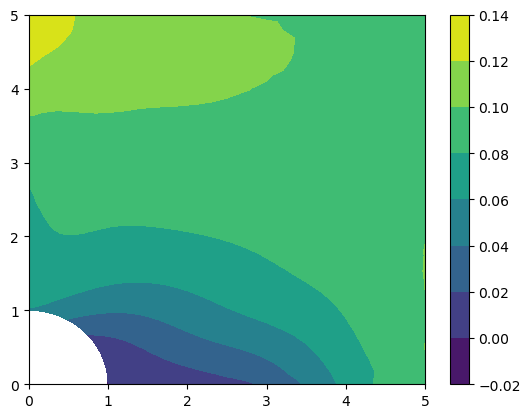

In [21]:
# Plot the stress
import matplotlib.tri as mtri

stiff = E / (1 - mu ** 2) * torch.tensor([[1, mu, 0], [mu, 1, 0], [0, 0, (1 - mu) / 2]])
stiff = stiff.unsqueeze(0)

stiff_bc = stiff
stiff_full = stiff
stiff = torch.broadcast_to(stiff, (len(x), 3, 3))

stiff_bc = torch.broadcast_to(stiff_bc, (len(Boundary), 3, 3))
stiff_full = torch.broadcast_to(stiff_full, (len(x_full), 3, 3))

u_full = disp_net(x_full)
stress_full = stress_net(x_full)

xx = x_full[:,0].detach().numpy()
yy = x_full[:,1].detach().numpy()
sig11 = stress_full[:,1].detach().numpy()

connect =(t_connect -1).detach().numpy()

triang = mtri.Triangulation(xx, yy, connect)

u_11 = u_full[:,0].detach().numpy()

u = u_full[:, 0]
v = u_full[:, 1]

dudx = torch.autograd.grad(u, x_full, grad_outputs=torch.ones_like(u), create_graph=True)[0]
dvdx = torch.autograd.grad(v, x_full, grad_outputs=torch.ones_like(v), create_graph=True)[0]

e_11 = dudx[:, 0].unsqueeze(1)
e_22 = dvdx[:, 1].unsqueeze(1)
e_12 = 0.5 * (dudx[:, 1] + dvdx[:, 0]).unsqueeze(1)

e = torch.cat((e_11, e_22, e_12), 1)
e = e.unsqueeze(2)

sigma = torch.bmm(stiff_full, e).squeeze(2)

plt.figure(2)
plt.clf()
plt.tricontourf(triang,sigma[:,0].detach().numpy())
plt.colorbar()
plt.savefig('pde_loss.png')
plt.show()

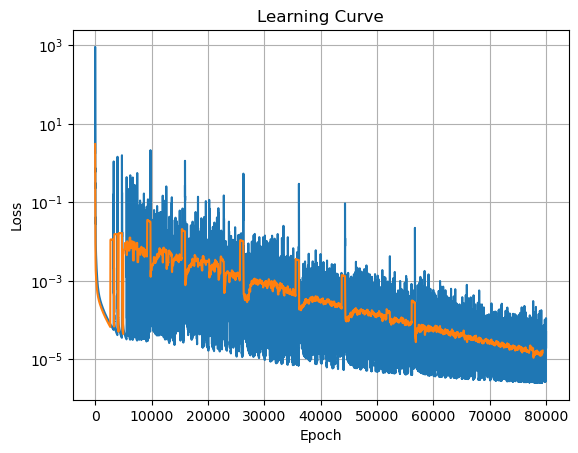

In [20]:
#Plot and save the learning curve with moving average
ma = np.convolve(loss_train_list, np.ones(600)/600, mode='valid')
plt.figure(3)
plt.plot(loss_train_list, label='Loss')
plt.plot(ma, label='Moving Average')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.semilogy()
plt.title('Learning Curve')
plt.grid(True)
plt.savefig('pde_loss_learning_curve.png')
plt.show()

In [19]:
#Save the model checkpoint
torch.save(disp_net.state_dict(), 'disp_model_pde.pth')
torch.save(stress_net.state_dict(), 'stress_model_pde.pth')